# CSI5155 Assignemnt 2
<br>Thomas Sloan tsloa055@uottawa.ca 300437450
<br>
## Table of Contents:


In [199]:
import os
import numpy as np 
import pandas as pd 
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
warnings.filterwarnings("ignore")
pd.set_option("display.max_rows",None)
import matplotlib 
matplotlib.style.use('ggplot')
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score,roc_auc_score
from sklearn.model_selection import train_test_split
import shap



## Import the data
The data is imported here. I also renamed many of the column names (excl. age, sex) because I didn't like their label. The new labels are from the explanation document where they explain what each label is, with the first letter capatilzed and the name only shorted for common aconyms.

In [200]:
df=pd.read_csv("./heart.csv")
df.rename(columns={'cp': 'ChestPainType', 
                   'trtbps': 'RestingBP',
                   'chol':'Cholesterol',
                   'fbs':'FastingBS',
                   'restecg':'RestingECG',
                   'thalachh':'MaxHR',
                   'exng':'ExerciseAngina',
                   'oldpeak':'OldPeak',
                   'thall':'Thalium',
                   'slp':'Slope',
                   'caa':'MajorBloodVessels'}, inplace=True)
df.head()

,age,sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,OldPeak,Slope,MajorBloodVessels,Thalium,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


## Preprocessing
No label encoding is done because the values are all numerical. No Imputation is required since there are no null/missing values found

In [201]:
# Get the types of each column. Since the values are all numerical, no label encoding is required
print("Types of each column")
print(df.dtypes)
print("\n\nShape of the dataset")
print(df.describe().T)
print("\n\nChecking for null values")
print(df.isnull().sum())

Types of each column
age                    int64
sex                    int64
ChestPainType          int64
RestingBP              int64
Cholesterol            int64
FastingBS              int64
RestingECG             int64
MaxHR                  int64
ExerciseAngina         int64
OldPeak              float64
Slope                  int64
MajorBloodVessels      int64
Thalium                int64
output                 int64
dtype: object


Shape of the dataset
                   count        mean        std    min    25%    50%    75%  \
age                303.0   54.366337   9.082101   29.0   47.5   55.0   61.0   
sex                303.0    0.683168   0.466011    0.0    0.0    1.0    1.0   
ChestPainType      303.0    0.966997   1.032052    0.0    0.0    1.0    2.0   
RestingBP          303.0  131.623762  17.538143   94.0  120.0  130.0  140.0   
Cholesterol        303.0  246.264026  51.830751  126.0  211.0  240.0  274.5   
FastingBS          303.0    0.148515   0.356198    0.0    0.0 

In [202]:
# Creating list of column names
column_names=df.columns.to_list()
column_names.remove('output')
column_names

['age',
 'sex',
 'ChestPainType',
 'RestingBP',
 'Cholesterol',
 'FastingBS',
 'RestingECG',
 'MaxHR',
 'ExerciseAngina',
 'OldPeak',
 'Slope',
 'MajorBloodVessels',
 'Thalium']

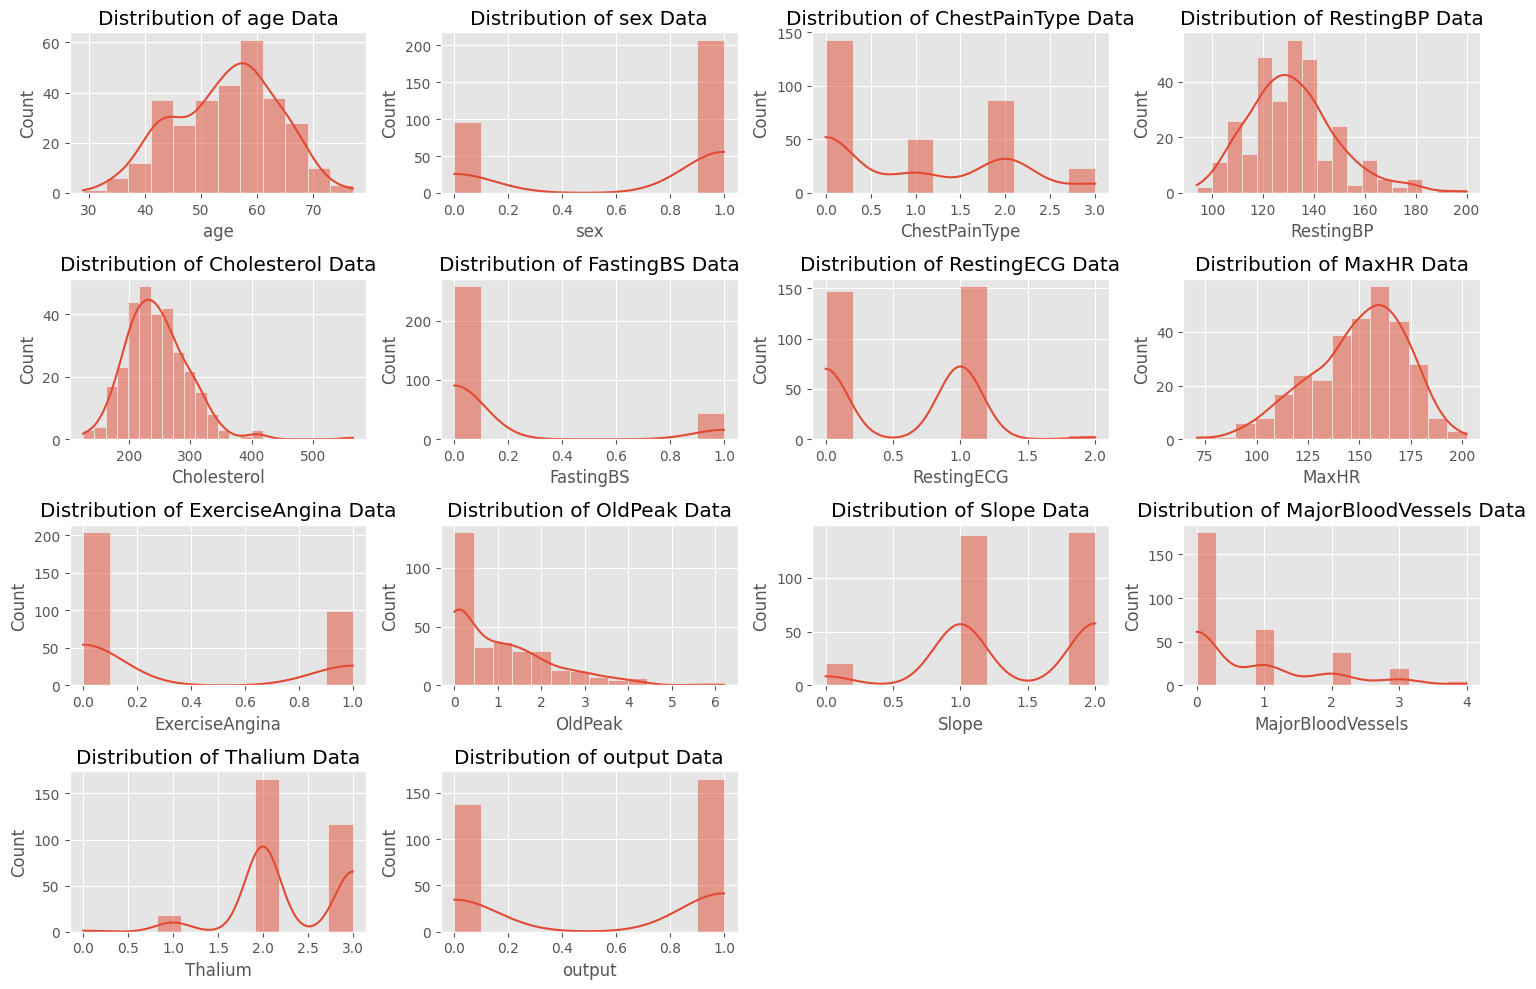

In [203]:

plt.figure(figsize=(15,10))

for i, col in enumerate(df.columns,1):
    plt.subplot(4,4,i)
    plt.title(f"Distribution of {col} Data")
    sns.histplot(df[col],kde=True)
    plt.tight_layout()
    plt.plot()


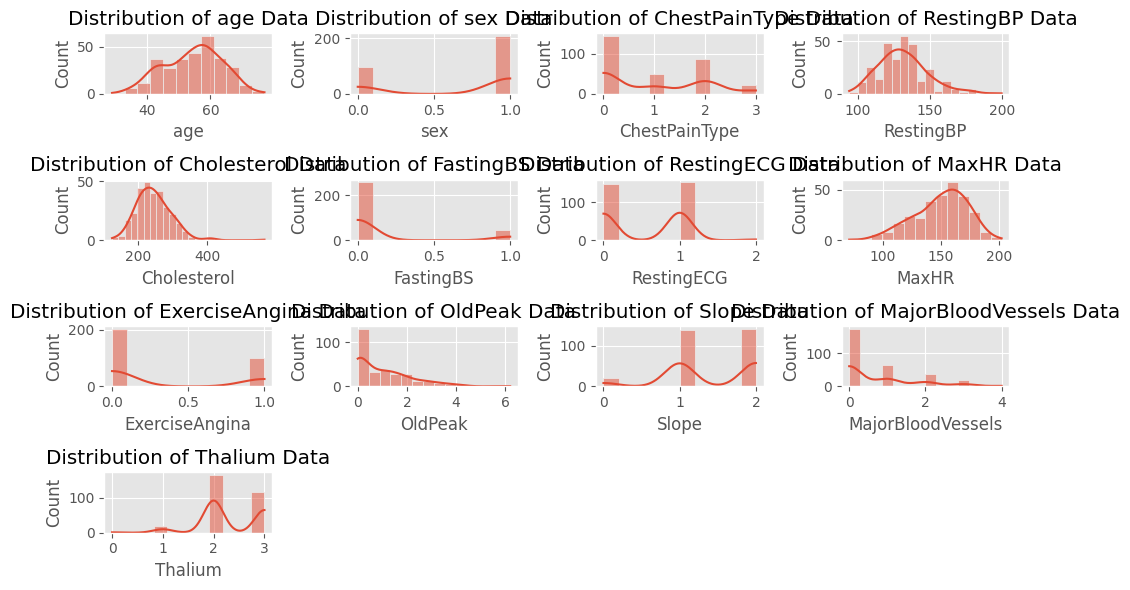

In [204]:
plt.figure(figsize=(10, 6))  # Change the figsize to a smaller size

for i, col in enumerate(column_names, 1):
    plt.subplot(4, 4, i)
    plt.title(f"Distribution of {col} Data")
    sns.histplot(df[col], kde=True)
    plt.tight_layout()
    plt.plot()
    
    fig = px.box(df, y=col, x="output", title=f"Distribution of {col} Data")
    fig.update_layout(
        autosize=False,
        width=400,
        height=400,
        )
    fig.show()


## Processing

In [205]:
target = "output"
y=df[target]
x=df.drop(target,axis=1)

# verify that the classification is binary
y.value_counts()

output
1    165
0    138
Name: count, dtype: int64

In [206]:


rf = RandomForestClassifier()
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=42)
rf.fit(X_train[column_names],y_train)
y_pred=rf.predict(X_test[column_names])
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

roc_auc_score(y_test, y_pred)

Confusion Matrix:
[[24  5]
 [ 3 29]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.83      0.86        29
           1       0.85      0.91      0.88        32

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.87      0.87      0.87        61



0.8669181034482758

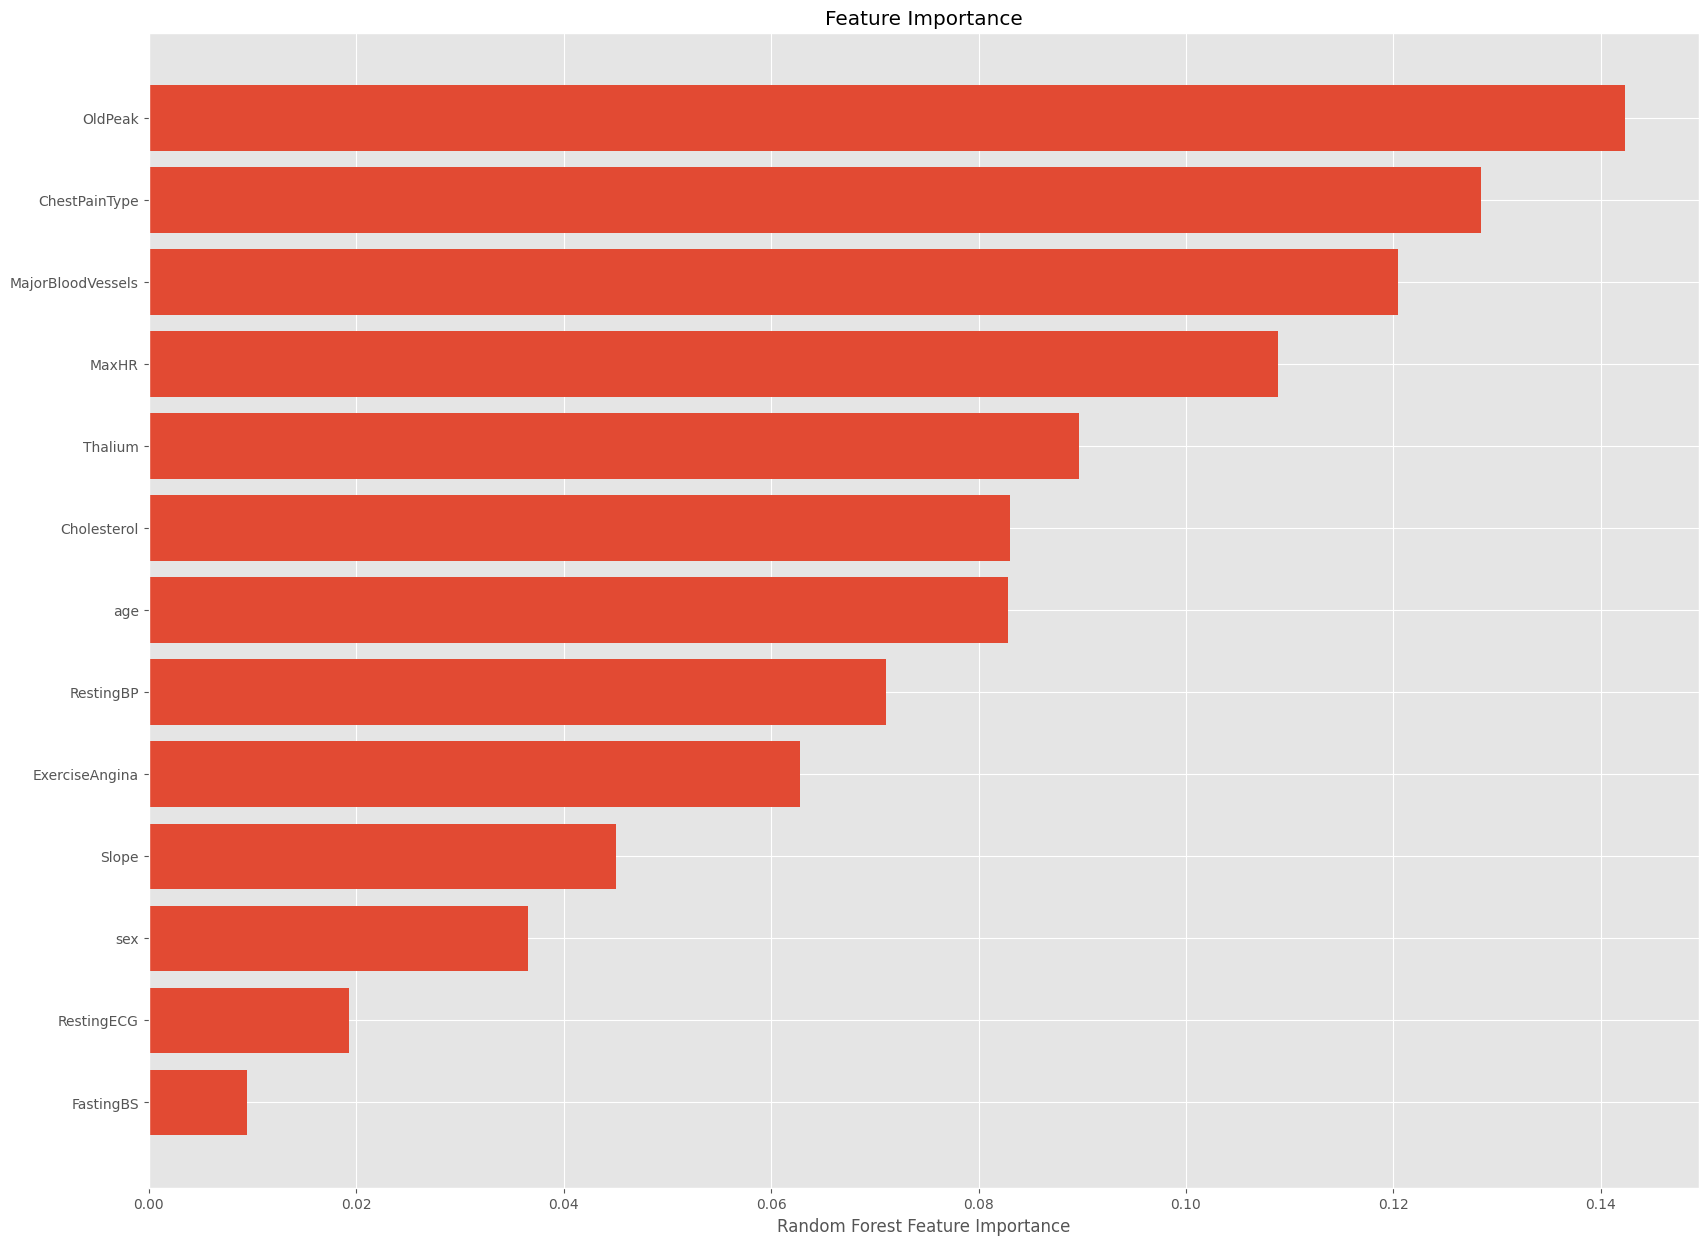

In [207]:
## Checking Feature importance 

plt.figure(figsize=(20,15))
importance = rf.feature_importances_
idxs = np.argsort(importance)
plt.title("Feature Importance")
plt.barh(range(len(idxs)),importance[idxs],align="center")
plt.yticks(range(len(idxs)),[column_names[i] for i in idxs])
plt.xlabel("Random Forest Feature Importance")
#plt.tight_layout()
plt.show()

In [208]:
shap.initjs()
# # Calculate SHAP values
explainer = shap.TreeExplainer(rf)
shap_values = explainer(X_test)
sv = explainer.shap_values(X_test)

exp = shap.Explanation(shap_values.values[:,:,1], 
                  shap_values.base_values[:,1], 
                  data=X_test.values, 
                  feature_names=X_test.columns)
idx = 0

# shap.summary_plot(sv[...,1], X_test)
# shap.waterfall_plot(exp[idx], max_display=len(column_names)+1)
# shap.decision_plot(explainer.expected_value[idx], sv[...,1], features=X_test)
# for i, col in enumerate(column_names, 1):
#     shap.dependence_plot(f"{col}", sv[..., 1], X_test, show=False)
#     plt.title(f"Feature Dependence Plot of {col}")
#     plt.tight_layout()
#     plt.show()
shap.force_plot(explainer.expected_value[idx], sv[...,1], features=X_test,link="logit")


Force


Summary
Sorts based on importance/impact on prediction. logOdds value on X axis. Every dot is a sample. Very red means that it has a big numerical value. blue means small numerical value. If far left then it means  causes output of 0, far right  causes output of 1. Purple means medium value.

Waterfall
E[f(x)] is the average predicted heart attact for testd people. f(x) is the predicted value for this person. The values on the y axis are the feature values for this person. The values on the plot show how much each value changes the prediction
log odds.